# Exercise 1

In [53]:
from thinkdsp import Signal, Sinusoid, SquareSignal, TriangleSignal, SawtoothSignal, ParabolicSignal
from thinkdsp import normalize, unbias, PI2, decorate
from thinkdsp import Chirp
from thinkdsp import read_wave
from thinkdsp import Spectrum, Wave, UncorrelatedGaussianNoise, Spectrogram

import numpy as np
import pandas as pd

from matplotlib import pyplot

import thinkstats2

from scipy.stats import linregress

import scipy
import scipy.fftpack

def analyze1(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Works for the general case where M is not orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Assumes that fs and ts are chosen so that M is orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

loglog = dict(xscale='log', yscale='log')

PI2 = np.pi * 2

Testing analyze1...
For 64 samples:
2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
For 128 samples:
4.41 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
For 256 samples:
13.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
For 512 samples:
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
For 1024 samples:
62.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
For 2048 samples:
253 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
For 4096 samples:
1.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Testing analyze2...
For 64 samples:
74.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
For 128 samples:
479 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
For 256 samples:
1.97 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
For 512 samples:
5.46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
For 1024 samples:
19.6 ms ± 0 ns 

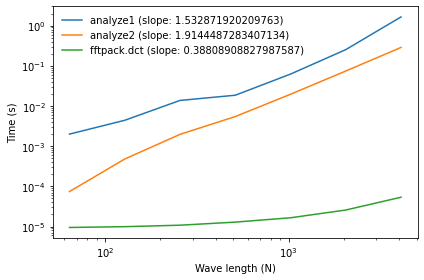

In [18]:
def run_speed_test(counts, code, noise):
    results = []
    
    for count in counts:
        print(f'For {count} samples:')
        ts = (0.5 + np.arange(count)) / count
        freqs = (0.5 + np.arange(count)) / 2
        ys = noise.ys[:count]
        result = %timeit -r1 -o code(ys, freqs, ts)
        results.append(result)
        
    return [result.best for result in results]

def fit_slope(counts, results):
    x = np.log(counts)
    y = np.log(results)
    return linregress(x, y).slope

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)

print('Testing analyze1...')
counts = 2 ** np.arange(6, 13)
results1 = run_speed_test(counts, analyze1, noise)
slope1 = fit_slope(counts, results1)
print('')

print('Testing analyze2...')
results2 = run_speed_test(counts, analyze2, noise)
slope2 = fit_slope(counts, results2)
print('')

print('Testing scipy_dct...')
results3 = run_speed_test(counts, scipy_dct, noise)
slope3 = fit_slope(counts, results3)

pyplot.plot(counts, results1, label=f'analyze1 (slope: {slope1})')
pyplot.plot(counts, results2, label=f'analyze2 (slope: {slope2})')
pyplot.plot(counts, results3, label=f'fftpack.dct (slope: {slope3})')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

# Exercise 2

In [20]:
wave = read_wave('Sounds/100475__iluppai__saxophone-weep.wav')
wave.make_audio()

In [21]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

In [58]:
def compress(dct, threshold=1, log=False):
    count = 0
    
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < threshold:
            dct.hs[i] = 0
            count += 1
            
    total = len(dct.amps)
    
    if log:
        print(f'Total: {total}, Removed: {count} = {100 * count / total:.1f}%', sep='\t')
    
    return 100 * count / total

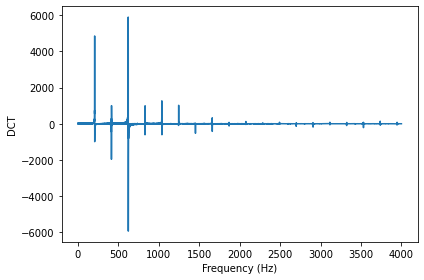

Total: 22050, Removed: 21919 = 99.4%


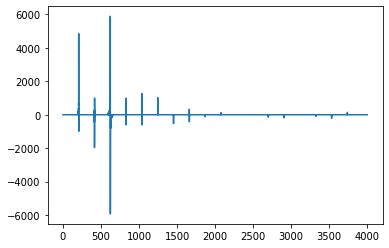

In [59]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

pyplot.show()
seg_dct = segment.make_dct()
compress(seg_dct, threshold=100, log=True)
seg_dct.plot(high=4000)

In [34]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

In [60]:
def make_dct_spectrogram(wave, segment_length):
    window = np.hamming(segment_length)
    i, j = 0, segment_length
    step = segment_length // 2
    spectrums = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spectrums[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spectrums, segment_length)

def compress_by_parts(wave, segment_length):
    spectrogram = make_dct_spectrogram(wave, segment_length=segment_length)
    average = 0
    
    for t, dct in sorted(spectrogram.spec_map.items()):
        average += compress(dct, threshold=0.2)
        
    average /= len(spectrogram.spec_map)
    
    print(f'Average: {average:.1f}%', sep='\t')
    
    return spectrogram

wave2 = compress_by_parts(wave, 512).make_wave()
wave2.make_audio()

Average: = 80.9%


# Exercise 4

In [100]:
from thinkdsp import Noise

class MyUncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = numpy.random.poisson(self.amp, len(ts))
        return ys
    
signal = MyUncorrelatedPoissonNoise(amp=0.001)
wave = signal.make_wave(duration=10, framerate=10_000)
wave.make_audio()

In [101]:
sum(wave.ys), 0.001 * 10_000 * 10

(108, 100.0)

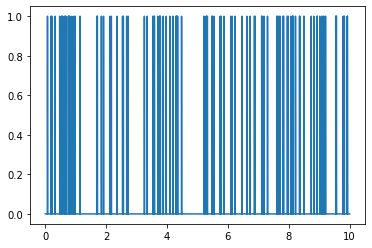

In [102]:
wave.plot()

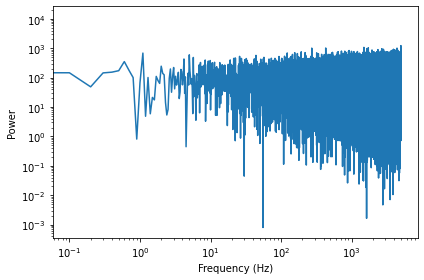

In [103]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

In [104]:
spectrum.estimate_slope().slope

0.003588744475416015

# Exercise 5

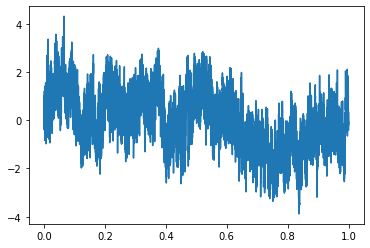

In [113]:
def voss(rows, columns=16):
    array = numpy.empty((rows, columns))
    array.fill(numpy.nan)
    
    array[0, :] = numpy.random.random(columns)
    array[:, 0] = numpy.random.random(rows)
    
    target_columns = numpy.random.geometric(0.5, rows)
    target_columns[target_columns >= columns] = 0
    
    target_rows = numpy.random.randint(rows, size=rows)
    
    array[target_rows, target_columns] = numpy.random.random(rows)

    dataframe = pandas.DataFrame(array)
    dataframe.fillna(method='ffill', axis=0, inplace=True)
    
    total = dataframe.sum(axis=1)
    return total.values

wave = Wave(voss(11025))
wave.unbias()
wave.plot()
wave.make_audio()

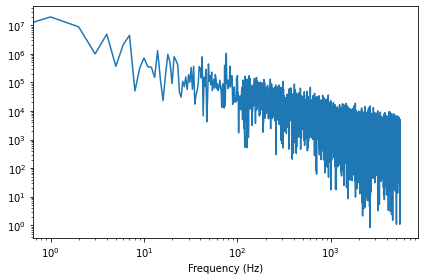

In [115]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         **loglog)

In [116]:
spectrum.estimate_slope().slope

-1.0086281113773163